# Recurrent Neural Network with Tensorflow API

## Creating and Plotting the data

Give the model a series = [0, 0.84, 0.91, 0.14, -0.75, -0.96, -0.28] and see what the next is

Actually it is Sin(x)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# Create a Class that will be able to create the data and also generate batches 
# to send back

class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        
        self.resolution = (self.xmax - self.xmin)/self.num_points
        # Defining x for num_points points
        self.x_data = np.linspace(start = self.xmin,
                                  stop = self.xmax,
                                  num = self.num_points)
        # Getting the Sin(x) for all of the x_data points
        self.y_true = np.sin(self.x_data)
    
    # Returns the sin of an input array
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    
    def next_batch(self, batch_size, steps, return_batch_time_series=False):
        
        # Grab a random starting point for each batch
        rand_start =np.random.rand(batch_size, 1)
        
        # Convert the random start to be lying somewhere on the time series
        time_series_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        # Create a batch time series on the x-axis
        batch_time_series = time_series_start + np.arange(0.0, steps+1) * self.resolution
        
        # Create a corresponding y_data for each of the x_data points
        y_batch = np.sin(batch_time_series)
        
        # Format the whole thing for RNN
        if return_batch_time_series:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), batch_time_series
        else:
            # first batch represents the time series, second batch reprersents the 
            # series shifted over by one step into the future so we can train
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)
        

In [25]:
# Creating Data
ts_data = TimeSeriesData(num_points=250, xmin=0, xmax=10)

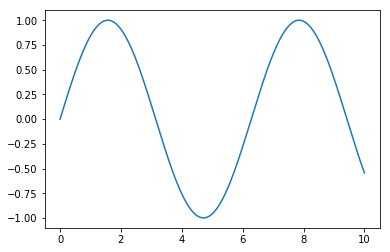

In [26]:
# Plotting the data
plt.plot(ts_data.x_data, ts_data.y_true);

In [32]:
# Each of my random batches should have 30 steps in it
num_time_steps = 30

In [33]:
# I need 1 batch of 30 time steps with the batch time series
y1, y2, ts = ts_data.next_batch(batch_size=1, steps=num_time_steps, return_batch_time_series=True)

In [34]:
ts

array([[5.15971414, 5.19971414, 5.23971414, 5.27971414, 5.31971414,
        5.35971414, 5.39971414, 5.43971414, 5.47971414, 5.51971414,
        5.55971414, 5.59971414, 5.63971414, 5.67971414, 5.71971414,
        5.75971414, 5.79971414, 5.83971414, 5.87971414, 5.91971414,
        5.95971414, 5.99971414, 6.03971414, 6.07971414, 6.11971414,
        6.15971414, 6.19971414, 6.23971414, 6.27971414, 6.31971414,
        6.35971414]])

In [35]:
ts.shape

(1, 31)

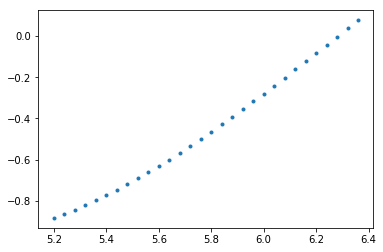

In [36]:
# Plotting
plt.plot(ts.flatten()[1:], y2.flatten(), '.')

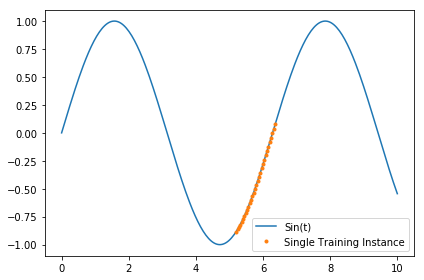

In [37]:
# Original Sine wave
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '.', label='Single Training Instance')
plt.legend()
plt.tight_layout() # automatic padding for legibility

In [39]:
# Training Data

train_inst = np.linspace(5, 5 + ts_data.resolution*(num_time_steps+1), num_time_steps+1)
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

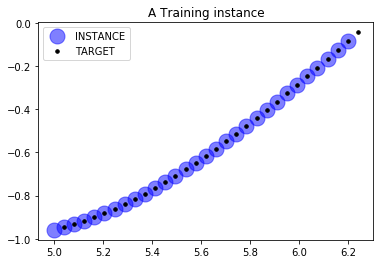

In [45]:
plt.title("A Training instance")
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, 
        label='INSTANCE');
# We need to predict exactly one time step forward
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]), 'k.', markersize=7, label='TARGET')
plt.legend();

Now this graph is interpreted as - Given the blue points, can you generate the black points?

## Creating the Model

In [46]:
tf.reset_default_graph() # Obligatory

In [47]:
num_inputs = 1 # We only have one feature ie the value of x
num_neurons = 100
num_outputs = 1
learning_rate = 0.001
num_training_iterations = 2000
batch_size = 1

# PLACEHOLDERS
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

# RNN CELL LAYER
cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons,
                                  activation=tf.nn.relu)
# We just need 1 time series output, we are using 100 neurons, but we dont need 100 outputs
# So we use an output projection wrapper
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_outputs)
# Operator adding an output projection to the given cell.
# Note: in many cases it may be more efficient to not use this wrapper,
# but instead concatenate the whole sequence of your outputs in time,
# do the projection on this batch-concatenated sequence, then split it
# if needed or directly feed into a softmax.